Plotting AWS-hosted NEXRAD Level 2 Data
=======================================================

Access NEXRAD radar data via Amazon Web Services and plot with MetPy

Accessing data remotely is a powerful tool for big data, such as NEXRAD radar data.
By accessing it in the cloud, you can save time and space from downloading the data locally.

In [1]:
import boto3
import botocore
from botocore.client import Config
import matplotlib.pyplot as plt
from metpy.io import Level2File
from metpy.plots import add_timestamp, ctables
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

Access the data in the AWS cloud. In this example, we're plotting data
from the Evansville, IN radar, which had convection within its
domain on 06/26/2019.


In [2]:
s3 = boto3.resource('s3', config=Config(signature_version=botocore.UNSIGNED,
                                        user_agent_extra='Resource'))
bucket = s3.Bucket('noaa-nexrad-level2')
for obj in bucket.objects.filter(Prefix='2019/06/26/KVWX/KVWX20190626_221105_V06'):
    print(obj.key)

    # Use MetPy to read the file
    f = Level2File(obj.get()['Body'])

2019/06/26/KVWX/KVWX20190626_221105_V06


Subset Data
-----------

With the file comes a lot of data, including multiple elevations and products.
In the next block, we'll pull out the specific data we want to plot.


In [3]:
sweep = 0
# First item in ray is header, which has azimuth angle
az = np.array([ray[0].az_angle for ray in f.sweeps[sweep]])

ref_hdr = f.sweeps[sweep][0][4][b'REF'][0]
ref_range = np.arange(ref_hdr.num_gates) * ref_hdr.gate_width + ref_hdr.first_gate
ref = np.array([ray[4][b'REF'][1] for ray in f.sweeps[sweep]])

rho_hdr = f.sweeps[sweep][0][4][b'RHO'][0]
rho_range = (np.arange(rho_hdr.num_gates + 1) - 0.5) * rho_hdr.gate_width + rho_hdr.first_gate
rho = np.array([ray[4][b'RHO'][1] for ray in f.sweeps[sweep]])

phi_hdr = f.sweeps[sweep][0][4][b'PHI'][0]
phi_range = (np.arange(phi_hdr.num_gates + 1) - 0.5) * phi_hdr.gate_width + phi_hdr.first_gate
phi = np.array([ray[4][b'PHI'][1] for ray in f.sweeps[sweep]])

zdr_hdr = f.sweeps[sweep][0][4][b'ZDR'][0]
zdr_range = (np.arange(zdr_hdr.num_gates + 1) - 0.5) * zdr_hdr.gate_width + zdr_hdr.first_gate
zdr = np.array([ray[4][b'ZDR'][1] for ray in f.sweeps[sweep]])

Plot the data
-------------

Use MetPy and Matplotlib to plot the data


/home/travis/miniconda/envs/unidata/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


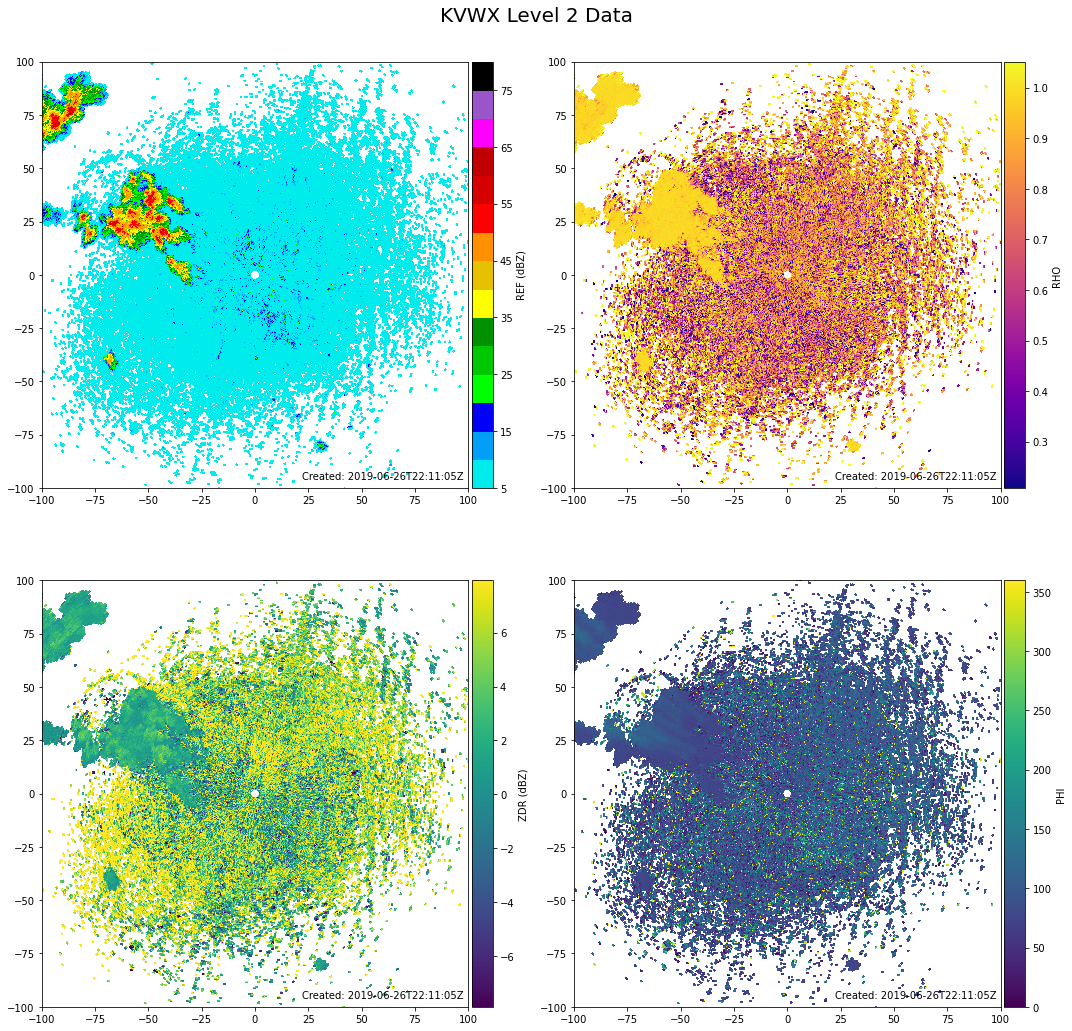

In [4]:
# Get the NWS reflectivity colortable from MetPy
ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSReflectivity', 5, 5)

# Plot the data!
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
for var_data, var_range, colors, lbl, ax in zip((ref, rho, zdr, phi),
                                                (ref_range, rho_range, zdr_range, phi_range),
                                                (ref_cmap, 'plasma', 'viridis', 'viridis'),
                                                ('REF (dBZ)', 'RHO', 'ZDR (dBZ)', 'PHI'),
                                                axes.flatten()):
    # Turn into an array, then mask
    data = np.ma.array(var_data)
    data[np.isnan(data)] = np.ma.masked

    # Convert az,range to x,y
    xlocs = var_range * np.sin(np.deg2rad(az[:, np.newaxis]))
    ylocs = var_range * np.cos(np.deg2rad(az[:, np.newaxis]))

    # Define norm for reflectivity
    norm = ref_norm if colors == ref_cmap else None

    # Plot the data
    a = ax.pcolormesh(xlocs, ylocs, data, cmap=colors, norm=norm)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(a, cax=cax, orientation='vertical', label=lbl)

    ax.set_aspect('equal', 'datalim')
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
    add_timestamp(ax, f.dt, y=0.02, high_contrast=False)
plt.suptitle('KVWX Level 2 Data', fontsize=20)
plt.tight_layout()